## LSTM Advanced

https://towardsdatascience.com/multiple-stock-prediction-using-deep-learning-network-d19a7acd8551

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

### Load dataset

In [189]:
stock = ['^BFX', '^AEX', '^FCHI' ]
start = pd.to_datetime('2016-01-01')
df = web.DataReader(stock, data_source = 'yahoo', start = start )

In [190]:
df.head()

Attributes    Adj Close                                 Close              \
Symbols            ^BFX        ^AEX        ^FCHI         ^BFX        ^AEX   
Date                                                                        
2016-01-04  3642.790039  431.700012  4522.450195  3642.790039  431.700012   
2016-01-05  3653.179932  435.000000  4537.629883  3653.179932  435.000000   
2016-01-06  3613.689941  428.760010  4480.470215  3613.689941  428.760010   
2016-01-07  3550.709961  420.760010  4403.580078  3550.709961  420.760010   
2016-01-08  3493.979980  410.820007  4333.759766  3493.979980  410.820007   

Attributes                      High                                   Low  \
Symbols           ^FCHI         ^BFX        ^AEX        ^FCHI         ^BFX   
Date                                                                         
2016-01-04  4522.450195  3673.669922  436.970001  4586.109863  3624.030029   
2016-01-05  4537.629883  3681.540039  436.720001  4575.450195  3615.469971   
2016-01-06  4480.470215  3650.719971  433.950012  4533.240234  3588.110107   
2016-01-07  4403.580078  3569.060059  423.290009  4424.140137  3500.439941   
2016-01-08  4333.759766  3569.870117  423.059998  4437.020020  3493.979980   

Attributes                                  Open                           \
Symbols           ^AEX        ^FCHI         ^BFX        ^AEX        ^FCHI   
Date                                                                        
2016-01-04  427.220001  4490.299805  3672.810059  436.970001  4582.049805   
2016-01-05  428.690002  4481.700195  3672.040039  436.140015  4573.540039   
2016-01-06  424.640015  4440.770020  3648.020020  433.649994  4528.120117   
2016-01-07  411.970001  4323.549805  3549.860107  417.339996  4346.100098   
2016-01-08  410.820007  4333.740234  3548.750000  421.220001  4404.180176   

Attributes Volume                            
Symbols      ^BFX         ^AEX        ^FCHI  
Date                                         
2016-01-04    0.0  100628200.0  130633900.0  
2016-01-05    0.0   89035800.0  104182900.0  
2016-01-06    0.0   98948900.0  104877300.0  
2016-01-07    0.0  132507500.0  137701000.0  
2016-01-08    0.0  126101000.0  124197200.0

In [191]:
df.isnull().values.any()

True

In [192]:
df.dropna(inplace=True)

In [193]:
df.isnull().values.any()

False

### Split train/test

In [195]:
data = df [['Close']]
data = data.reset_index()

training_data = data[data['Date'] < pd.to_datetime('2020-01-01')].copy()
test_data = data[data['Date'] >= pd.to_datetime("2020-01-01")].copy()

training_data = training_data.set_index('Date')
test_data = test_data.set_index('Date')

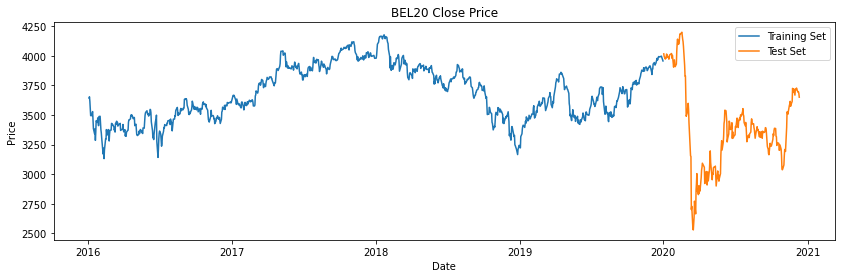

In [196]:
plt.figure(figsize=(14,4))
plt.plot(training_data.Close['^BFX'])
plt.plot(test_data.Close['^BFX'])
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.title("BEL20 Close Price")
plt.show()

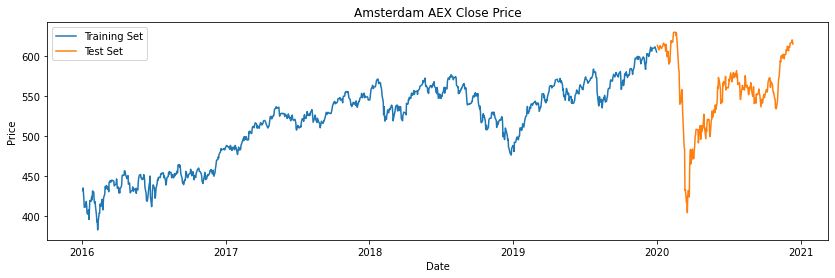

In [197]:
plt.figure(figsize=(14,4))
plt.plot(training_data.Close['^AEX'])
plt.plot(test_data.Close['^AEX'])
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.title("Amsterdam AEX Close Price")
plt.show()

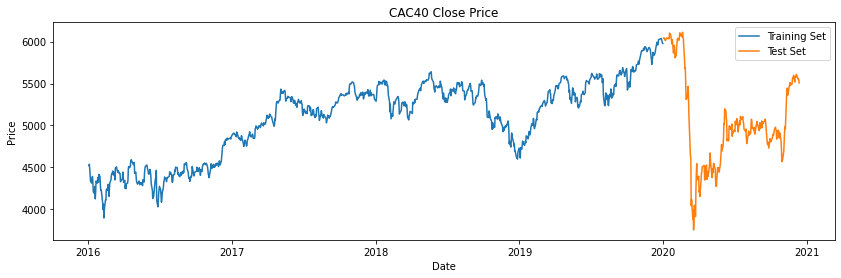

In [198]:
plt.figure(figsize=(14,4))
plt.plot(training_data.Close['^FCHI'])
plt.plot(test_data.Close['^FCHI'])
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(["Training Set", "Test Set"])
plt.title("CAC40 Close Price")
plt.show()

### Data normalization

In [199]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range = (0, 1))
minmax_single = MinMaxScaler(feature_range = (0, 1))
train_scaled = np.concatenate ([minmax.fit_transform (training_data.Close[['^BFX', '^AEX']].values), minmax_single.fit_transform(training_data.Close[['^FCHI']].values)], axis = 1)
train_scaled = pd.DataFrame(train_scaled, columns = training_data.columns) 
train_scaled 

Attributes     Close                    
Symbols         ^BFX      ^AEX     ^FCHI
0           0.489456  0.214930  0.292309
1           0.499388  0.229378  0.299400
2           0.461639  0.202058  0.272698
3           0.401436  0.167032  0.236780
4           0.347207  0.123511  0.204164
...              ...       ...       ...
1016        0.820986  0.992163  0.996254
1017        0.823395  0.992645  0.996337
1018        0.827429  1.000000  1.000000
1019        0.799545  0.977321  0.974228
1020        0.788696  0.971848  0.972284

[1021 rows x 3 columns]

### Shaping data for LSTM

In [200]:
train_scaled = train_scaled.values
n_lags = int(60)
X_train = []
y_train = []

for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

In [201]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))

# Check the shape (again) before start training
shape_chk = []
for i in stock:
    index = {}
    index["X_train"] = X_train.shape
    index["y_train"] = y_train.shape
    shape_chk.append(index)

pd.DataFrame(shape_chk, index=stock)

,X_train,y_train
^BFX,"(961, 60, 3)","(961,)"
^AEX,"(961, 60, 3)","(961,)"
^FCHI,"(961, 60, 3)","(961,)"


### LSTM Network

In [202]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers

In [203]:
# The LSTM architecture
regressor = Sequential()
# 1st layer with Dropout regularisation
regressor.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1],3)))
regressor.add(Dropout(0.2))
# 2nd LSTM layer
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.2))
# 3rd LSTM layer
regressor.add(LSTM(units=20, return_sequences=True))
regressor.add(Dropout(0.5))
# 4th LSTM layer
regressor.add(LSTM(units=20))
regressor.add(Dropout(0.5))
# Output layer
regressor.add(Dense(units=1))
# Compiling LSTM 
optimizer = optimizers.Adam(clipvalue=0.5)
regressor.compile(optimizer=optimizer, loss='mean_squared_error')
# Fitting to the training set
for i in stock:
    print("Fitting to", i)
    regressor.fit(X_train, y_train, epochs=10, batch_size=128)

Fitting to ^BFX
Epoch 1/10
961/961 [==============================] - 6s 6ms/step - loss: 0.2688
Epoch 2/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0792
Epoch 3/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0553
Epoch 4/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0483
Epoch 5/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0451
Epoch 6/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0345
Epoch 7/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0329
Epoch 8/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0328
Epoch 9/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0315
Epoch 10/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0293
Fitting to ^AEX
Epoch 1/10
961/961 [==============================] - 1s 1ms/step - loss: 0.0294
Epoch 2/10
961/961 [==============================] - 1s 1ms/step - loss: 0.

### Test data transformation

In [205]:
total_data = pd.concat((training_data, test_data), axis = 0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
test_scaled = np.concatenate([minmax.transform(inputs.Close[['^BFX', '^AEX']]),
minmax_single.transform(inputs.Close[['^FCHI']])], axis = 1)
print('Shape of test data:', test_scaled.shape)
# shaping data from neural network
X_test = []
y_test = []

for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))

Shape of test data: (303, 3)


### Prediction

In [206]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax_single.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: 'CAC40_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=0)
predicted_price.index = test_data.index

### Visualization

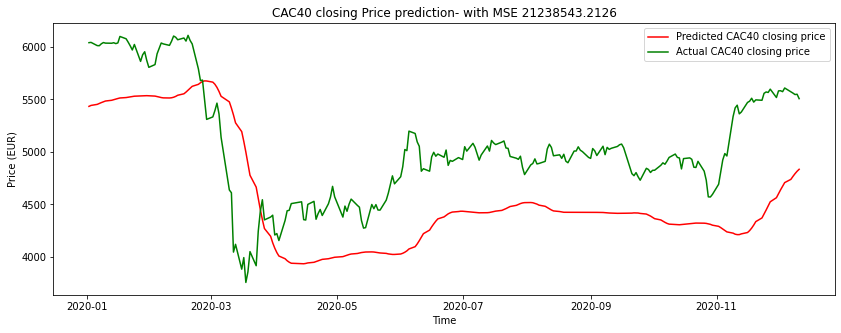

In [211]:
from sklearn.metrics import mean_squared_error
plt.figure(figsize = (14,5))
mse = mean_squared_error(y_test, predicted_price)

plt.plot(predicted_price['CAC40_predicted'], color = 'red', label = 'Predicted CAC40 closing price')
plt.plot(test_data.Close['^FCHI'], color = 'green', label = 'Actual CAC40 closing price')
plt.title ("CAC40 closing Price prediction- with MSE {:10.4f}".format(mse))
plt.xlabel('Time')
plt.ylabel('Price (EUR)')
plt.legend()